# Analysis of the relationship between financial variables and twitter data


#### - 1. Preprocessing

#### - 2. Pearson correlation

#### - 3. Linear Regression models

#### - 4. LinePlots 

In [1]:
import pickle
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [2]:
with open("data/master_df.obj", "rb") as f:
    df = pickle.load(f)
    
df.drop(columns=["exp_corprate_activities"],inplace=True)

In [3]:
df.columns

Index(['party', 'year', 'member_fee', 'mandate_holder_contributions_and_sim',
       'donations_indiv', 'donations_legal', 'income_business_participations',
       'income_other sources', 'income_events_sales', 'gov_funds',
       'other_income', 'income_total', 'exp_personnel',
       'exp_ongoing_operations', 'exp_general_political_work', 'exp_elec_camp',
       'exp_asset_management', 'exp_other_interest', 'exp_other', 'exp_total',
       'net', 'year_int', 'federal state', 'state', 'EU', 'federal state per',
       'state per', 'EU per', 'replyCount_sum', 'retweetCount_sum',
       'quoteCount_sum', 'tweet_count', 'neg_ave', 'pos_ave', 'neu_ave'],
      dtype='object')

### 1. scale financial numbers and twitter data

- we need to normalize certain variables since the range between the party is way to big!
- what normalization?
- use min-max sclaing within each party
- makes parties comparable, changes in relation to its capablities, otherwise comparing small and big parties would make no sense

In [4]:
df.columns

Index(['party', 'year', 'member_fee', 'mandate_holder_contributions_and_sim',
       'donations_indiv', 'donations_legal', 'income_business_participations',
       'income_other sources', 'income_events_sales', 'gov_funds',
       'other_income', 'income_total', 'exp_personnel',
       'exp_ongoing_operations', 'exp_general_political_work', 'exp_elec_camp',
       'exp_asset_management', 'exp_other_interest', 'exp_other', 'exp_total',
       'net', 'year_int', 'federal state', 'state', 'EU', 'federal state per',
       'state per', 'EU per', 'replyCount_sum', 'retweetCount_sum',
       'quoteCount_sum', 'tweet_count', 'neg_ave', 'pos_ave', 'neu_ave'],
      dtype='object')

In [5]:
col_to_transform = ['member_fee', 'mandate_holder_contributions_and_sim',
       'donations_indiv', 'donations_legal', 'income_business_participations',
       'income_other sources', 'income_events_sales', 'gov_funds',
       'other_income', 'income_total', 'exp_personnel',
       'exp_ongoing_operations', 'exp_general_political_work', 'exp_elec_camp',
       'exp_asset_management', 'exp_other_interest', 'exp_other', 'exp_total',
       'net', 'replyCount_sum', 'retweetCount_sum',
       'quoteCount_sum', 'tweet_count']

# define new since ColumnTransformer puts all transformed variables to the left
col_scaled_df = ['member_fee', 'mandate_holder_contributions_and_sim',
       'donations_indiv', 'donations_legal', 'income_business_participations',
       'income_other sources', 'income_events_sales', 'gov_funds',
       'other_income', 'income_total', 'exp_personnel',
       'exp_ongoing_operations', 'exp_general_political_work', 'exp_elec_camp',
       'exp_asset_management', 'exp_other_interest', 'exp_other', 'exp_total',
       'net', 'replyCount_sum', 'retweetCount_sum',
       'quoteCount_sum', 'tweet_count','party', 'year','year_int', 'federal state', 'state', 'EU', 'federal state per',
       'state per', 'EU per','neg_ave', 'pos_ave', 'neu_ave']

minmax_transformer = Pipeline(steps=[('minmax', MinMaxScaler())])
col_scaler = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('mm', minmax_transformer , col_to_transform)
        ])


def scale_df_subset(df,party_list):
    df_scaled = pd.DataFrame(columns=col_scaled_df)
    for p in party_list:
        subset = df[df["party"]==p]
        subset_scaled = col_scaler.fit_transform(subset)
        df_scaled = df_scaled.append(pd.DataFrame(subset_scaled, columns=col_scaled_df))
    return df_scaled

In [6]:
# scale variables
scaled_df = scale_df_subset(df,df.party.unique())
scaled_df.reset_index(inplace=True,drop=True)

# correct datatype for the variables where needed
scaled_df[col_to_transform] = scaled_df[col_to_transform].astype(float)
scaled_df[["neg_ave","neu_ave","pos_ave"]] = scaled_df[["neg_ave","neu_ave","pos_ave"]].astype(float)
scaled_df[['federal state', 'state', 'EU',
       'federal state per', 'state per', 'EU per']] = scaled_df[['federal state', 'state', 'EU',
       'federal state per', 'state per', 'EU per']].astype(float)


# introduce dummy variables for year
scaled_df["just_year"] = [str(i)[:4] for i in scaled_df.year]
df_year_dummies = pd.get_dummies(scaled_df.just_year)

# set up df for analysis with scaled variables and dummy variables
df_analysis = pd.concat([scaled_df,df_year_dummies],axis=1)

### 2. Pearson Correlation

In [7]:
# calc correlatin heatmeap

election_vars = ['federal state', 'state', 'EU',
       'federal state per', 'state per', 'EU per']
year_vars=[str(i) for i in range(2010,2020)]
finance_vars = ['member_fee', 'mandate_holder_contributions_and_sim',
       'donations_indiv', 'donations_legal', 'income_business_participations',
       'income_other sources', 'income_events_sales', 'gov_funds',
       'other_income', 'income_total','exp_personnel',
       'exp_ongoing_operations', 'exp_general_political_work', 'exp_elec_camp',
       'exp_asset_management', 'exp_other_interest', 'exp_other', 'exp_total',
       'net']

twitter_vars = ['replyCount_sum', 'retweetCount_sum',
       'quoteCount_sum', 'tweet_count','neg_ave', 'pos_ave', 'neu_ave']

# set up correlationmatrix between twitter and finance variables
df1 = df_analysis.loc[:,twitter_vars+year_vars]
df2 = df_analysis.loc[:,finance_vars+election_vars+year_vars]
corr_df = pd.concat([df1, df2], axis=1, keys=['df1', 'df2']).corr(method="pearson").loc['df1', 'df2']

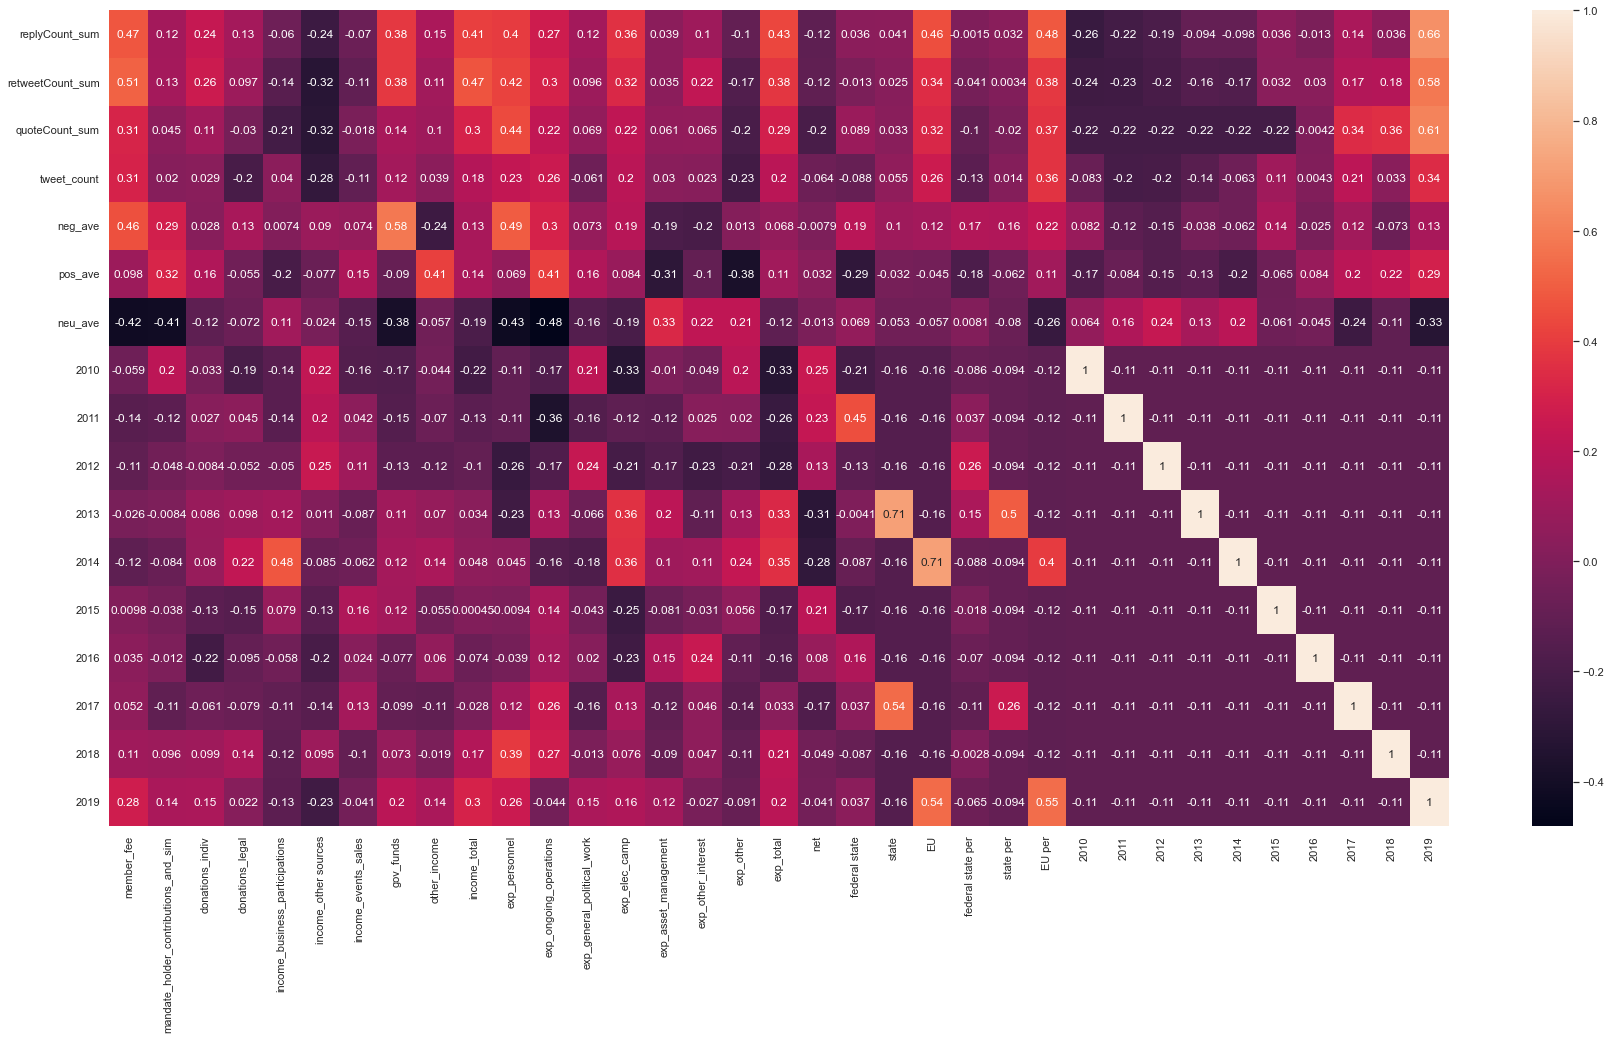

In [8]:
# plot correlation heatmap
sns.set(rc={'figure.figsize':(30,15)})
sns.heatmap(corr_df, annot = True)

plt.savefig("plots/corr_heatmap.png",bbox_inches='tight')
plt.show()

In [9]:
# drop neutral average because lack of interpretativity
# drop all variables with no correlation of at least abs(0.4)

corr_df_2 = corr_df.drop(labels=["neu_ave"],axis=0)
col_to_drop = []
for col_name in corr_df_2.columns:
    if max(corr_df_2[col_name]) < 0.4 and min(corr_df_2[col_name]) > -0.4:
        col_to_drop.append(col_name)

corr_df_2 = corr_df_2.drop(columns=col_to_drop)

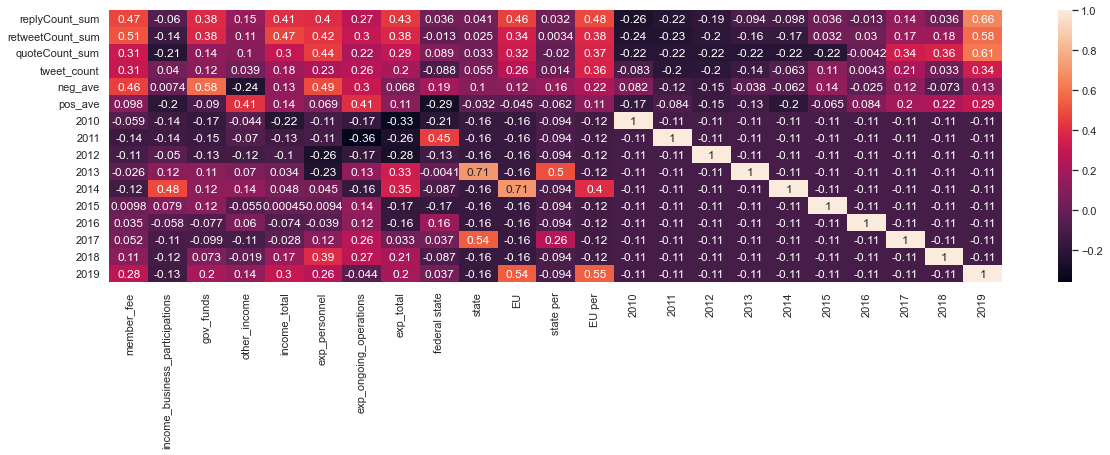

In [10]:
sns.set(rc={'figure.figsize':(20,5)})

sns.heatmap(corr_df_2, annot = True)
plt.savefig("plots/corr_heatmap_2.png",bbox_inches='tight')

plt.show()

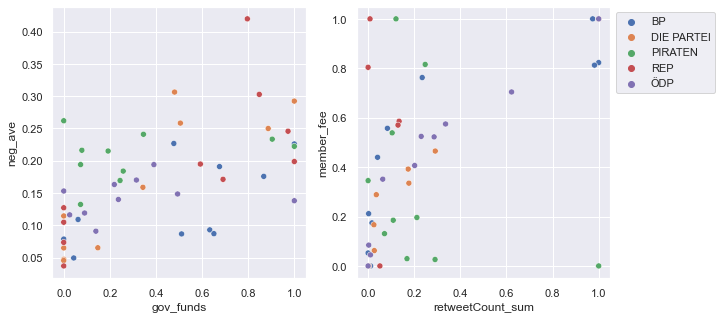

In [11]:
### plot some relationships with high correlation
# looks rather unreliable, parties have huge influence

fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(10,5))

sns.scatterplot(data=scaled_df,x="gov_funds",y="neg_ave", hue="party",ax=axs[0])
axs[0].get_legend().remove()

sns.scatterplot(data=scaled_df,x="retweetCount_sum",y="member_fee", hue="party",ax=axs[1])
axs[1].legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.savefig("plots/corr_scatter.png",bbox_inches='tight')


### 3. Linear Models

In [12]:
corr_df_2.columns

Index(['member_fee', 'income_business_participations', 'gov_funds',
       'other_income', 'income_total', 'exp_personnel',
       'exp_ongoing_operations', 'exp_total', 'federal state', 'state', 'EU',
       'state per', 'EU per', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019'],
      dtype='object')

In [13]:
# set up preprocessing pipeline

def load_reg_df(df,y_name):
    '''
    retuns y and X for linear regression statsmodel
    '''
    cols = list(corr_df_2.columns)
    
    df = df.dropna(axis=0,inplace=False)
    y = df[y_name]
    X = df[cols]
    
    return y,X

In [14]:
# set up empty dataframe for p_value matrix
df_pvalues = pd.DataFrame(columns=list(corr_df_2.columns))

#### replyCount_sum

In [15]:
y,X = load_reg_df(df_analysis,"replyCount_sum")
X = sm.add_constant(X)

model = sm.OLS(y,X.astype(float))
results = model.fit()
df_pvalues = df_pvalues.append(results.pvalues,ignore_index=True)
results.summary()


C:\Users\Lion\anaconda3\envs\wahlomat\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         replyCount_sum   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     14.52
Date:                Tue, 25 Jan 2022   Prob (F-statistic):           3.58e-08
Time:                        08:56:18   Log-Likelihood:                 48.277
No. Observations:                  42   AIC:                            -54.55
Df Residuals:                      21   BIC:                            -18.06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0032      0.062      0.052      0.959      -0.126       0.132
member_fee                         0.2268      0.101      2.250      0.035       0.017       0.436
income_business_participations     0.1699      0.108      1.577      0.130      -0.054       0.394
gov_funds                          0.0226      0.098      0.232      0.819      -0.180       0.226
other_income                       0.0383      0.075      0.512      0.614      -0.117       0.194
income_total                      -0.1212      0.104     -1.169      0.255      -0.337       0.094
exp_personnel                     -0.0422      0.081     -0.520      0.608      -0.211       0.127
exp_ongoing_operations             0.1233      0.074      1.676      0.109      -0.030       0.276
exp_total                          0.1259      0.109      1.159      0.259      -0.100       0.352
federal state                     -0.0004      0.019     -0.023      0.982      -0.039       0.038
state                              0.0564      0.041      1.365      0.187      -0.030       0.142
EU                                 0.2692      0.052      5.225      0.000       0.162       0.376
state per                         -0.1055      0.098     -1.077      0.294      -0.309       0.098
EU per                            -0.0781      0.077     -1.009      0.324      -0.239       0.083
2010                              -0.1162      0.056     -2.081      0.050      -0.232   -5.92e-05
2011                              -0.0232      0.075     -0.307      0.762      -0.180       0.134
2012                              -0.0555      0.048     -1.159      0.259      -0.155       0.044
2013                              -0.1111      0.052     -2.157      0.043      -0.218      -0.004
2014                              -0.3218      0.058     -5.593      0.000      -0.441      -0.202
2015                              -0.1175      0.059     -1.987      0.060      -0.240       0.005
2016                              -0.0491      0.064     -0.762      0.454      -0.183       0.085
2017                               0.1675      0.049      3.445      0.002       0.066       0.269
2018                               0.0390      0.072      0.541      0.594      -0.111       0.189
2019                               0.5910      0.054     10.917      0.000       0.478       0.704
==============================================================================
Omnibus:                        3.926   Durbin-Watson:                   1.507
Prob(Omnibus):                  0.140   Jarque-Bera (JB):                2.700
Skew:                           0.481   Prob(JB):                        0.259
Kurtosis:                       3.787   Cond. No.                     7.02e+16
===============

#### retweetCount_sum

In [16]:
y,X = load_reg_df(df_analysis,"retweetCount_sum")
X = sm.add_constant(X)

model = sm.OLS(y,X.astype(float))
results = model.fit()

df_pvalues = df_pvalues.append(results.pvalues,ignore_index=True)
results.summary()


C:\Users\Lion\anaconda3\envs\wahlomat\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       retweetCount_sum   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     7.234
Date:                Tue, 25 Jan 2022   Prob (F-statistic):           1.59e-05
Time:                        08:56:18   Log-Likelihood:                 30.707
No. Observations:                  42   AIC:                            -19.41
Df Residuals:                      21   BIC:                             17.08
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0932      0.094      0.991      0.333      -0.102       0.289
member_fee                         0.2697      0.153      1.761      0.093      -0.049       0.588
income_business_participations     0.0509      0.164      0.311      0.759      -0.289       0.391
gov_funds                         -0.1361      0.148     -0.918      0.369      -0.445       0.172
other_income                      -0.0314      0.114     -0.276      0.785      -0.268       0.205
income_total                       0.0580      0.157      0.368      0.716      -0.270       0.386
exp_personnel                     -0.0823      0.123     -0.667      0.512      -0.339       0.174
exp_ongoing_operations             0.0859      0.112      0.768      0.451      -0.147       0.318
exp_total                          0.1515      0.165      0.919      0.369      -0.192       0.495
federal state                     -0.0189      0.028     -0.672      0.509      -0.077       0.040
state                              0.0323      0.063      0.515      0.612      -0.098       0.163
EU                                 0.2270      0.078      2.899      0.009       0.064       0.390
state per                         -0.0386      0.149     -0.260      0.798      -0.348       0.271
EU per                            -0.0401      0.118     -0.341      0.736      -0.285       0.204
2010                              -0.1371      0.085     -1.615      0.121      -0.314       0.039
2011                              -0.0534      0.115     -0.466      0.646      -0.292       0.185
2012                              -0.1262      0.073     -1.734      0.098      -0.278       0.025
2013                              -0.1875      0.078     -2.396      0.026      -0.350      -0.025
2014                              -0.3417      0.087     -3.909      0.001      -0.523      -0.160
2015                              -0.1069      0.090     -1.190      0.247      -0.294       0.080
2016                               0.0251      0.098      0.256      0.800      -0.178       0.228
2017                               0.2199      0.074      2.976      0.007       0.066       0.374
2018                               0.2324      0.109      2.123      0.046       0.005       0.460
2019                               0.5687      0.082      6.914      0.000       0.398       0.740
==============================================================================
Omnibus:                        8.309   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                7.405
Skew:                           0.810   Prob(JB):                       0.0247
Kurtosis:                       4.267   Cond. No.                     7.02e+16
===============

#### quoteCount_sum

In [17]:
y,X = load_reg_df(df_analysis,"quoteCount_sum")
X = sm.add_constant(X)

model = sm.OLS(y,X.astype(float))
results = model.fit()

df_pvalues = df_pvalues.append(results.pvalues,ignore_index=True)
results.summary()

C:\Users\Lion\anaconda3\envs\wahlomat\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         quoteCount_sum   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     22.86
Date:                Tue, 25 Jan 2022   Prob (F-statistic):           4.85e-10
Time:                        08:56:18   Log-Likelihood:                 52.530
No. Observations:                  42   AIC:                            -63.06
Df Residuals:                      21   BIC:                            -26.57
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.1259      0.056      2.249      0.035       0.009       0.242
member_fee                         0.0035      0.091      0.038      0.970      -0.186       0.193
income_business_participations     0.0335      0.097      0.344      0.734      -0.169       0.236
gov_funds                         -0.0619      0.088     -0.701      0.491      -0.245       0.122
other_income                       0.0197      0.068      0.291      0.774      -0.121       0.160
income_total                       0.0137      0.094      0.146      0.885      -0.181       0.209
exp_personnel                      0.0069      0.073      0.094      0.926      -0.146       0.160
exp_ongoing_operations            -0.0356      0.066     -0.535      0.598      -0.174       0.103
exp_total                          0.1169      0.098      1.192      0.247      -0.087       0.321
federal state                      0.0071      0.017      0.425      0.675      -0.028       0.042
state                              0.0769      0.037      2.057      0.052      -0.001       0.155
EU                                 0.2139      0.047      4.592      0.000       0.117       0.311
state per                         -0.0373      0.089     -0.421      0.678      -0.221       0.147
EU per                            -0.0203      0.070     -0.290      0.774      -0.166       0.125
2010                              -0.1210      0.050     -2.396      0.026      -0.226      -0.016
2011                              -0.1485      0.068     -2.180      0.041      -0.290      -0.007
2012                              -0.1363      0.043     -3.149      0.005      -0.226      -0.046
2013                              -0.2463      0.047     -5.291      0.000      -0.343      -0.149
2014                              -0.4137      0.052     -7.958      0.000      -0.522      -0.306
2015                              -0.1281      0.053     -2.398      0.026      -0.239      -0.017
2016                               0.0712      0.058      1.225      0.234      -0.050       0.192
2017                               0.3231      0.044      7.353      0.000       0.232       0.415
2018                               0.2978      0.065      4.573      0.000       0.162       0.433
2019                               0.6276      0.049     12.827      0.000       0.526       0.729
==============================================================================
Omnibus:                       17.363   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.157
Skew:                          -1.130   Prob(JB):                     7.69e-07
Kurtosis:                       6.314   Cond. No.                     7.02e+16
===============

#### tweet_count

In [18]:
y,X = load_reg_df(df_analysis,"tweet_count")
X = sm.add_constant(X)

model = sm.OLS(y,X.astype(float))
results = model.fit()

df_pvalues = df_pvalues.append(results.pvalues,ignore_index=True)
results.summary()

C:\Users\Lion\anaconda3\envs\wahlomat\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            tweet_count   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     1.460
Date:                Tue, 25 Jan 2022   Prob (F-statistic):              0.198
Time:                        08:56:18   Log-Likelihood:                 8.6123
No. Observations:                  42   AIC:                             24.78
Df Residuals:                      21   BIC:                             61.27
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.3686      0.159      2.314      0.031       0.037       0.700
member_fee                         0.3852      0.259      1.486      0.152      -0.154       0.924
income_business_participations     0.0763      0.277      0.275      0.786      -0.500       0.652
gov_funds                         -0.3571      0.251     -1.423      0.170      -0.879       0.165
other_income                      -0.1729      0.192     -0.899      0.379      -0.573       0.227
income_total                      -0.2234      0.267     -0.838      0.411      -0.778       0.331
exp_personnel                     -0.0751      0.209     -0.360      0.723      -0.509       0.359
exp_ongoing_operations             0.0613      0.189      0.324      0.749      -0.332       0.455
exp_total                          0.1446      0.279      0.518      0.610      -0.436       0.725
federal state                     -0.0753      0.048     -1.582      0.129      -0.174       0.024
state                              0.0427      0.106      0.402      0.692      -0.178       0.264
EU                                 0.1105      0.133      0.834      0.414      -0.165       0.386
state per                          0.1649      0.252      0.655      0.520      -0.359       0.689
EU per                             0.2883      0.199      1.449      0.162      -0.126       0.702
2010                              -0.0570      0.144     -0.397      0.696      -0.356       0.242
2011                               0.0802      0.194      0.414      0.683      -0.323       0.483
2012                              -0.1317      0.123     -1.069      0.297      -0.388       0.124
2013                              -0.1634      0.132     -1.234      0.231      -0.439       0.112
2014                              -0.2133      0.148     -1.442      0.164      -0.521       0.094
2015                               0.0480      0.152      0.316      0.755      -0.268       0.364
2016                               0.1195      0.165      0.722      0.478      -0.225       0.464
2017                               0.2061      0.125      1.649      0.114      -0.054       0.466
2018                               0.1562      0.185      0.843      0.409      -0.229       0.542
2019                               0.3238      0.139      2.326      0.030       0.034       0.613
==============================================================================
Omnibus:                        7.629   Durbin-Watson:                   1.547
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                6.807
Skew:                           0.967   Prob(JB):                       0.0333
Kurtosis:                       3.385   Cond. No.                     7.02e+16
===============

#### neg_ave

In [19]:
y,X = load_reg_df(df_analysis,"neg_ave")
X = sm.add_constant(X)

model = sm.OLS(y,X.astype(float))
results = model.fit()

df_pvalues = df_pvalues.append(results.pvalues,ignore_index=True)
results.summary()

C:\Users\Lion\anaconda3\envs\wahlomat\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                neg_ave   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     3.558
Date:                Tue, 25 Jan 2022   Prob (F-statistic):            0.00282
Time:                        08:56:18   Log-Likelihood:                 79.183
No. Observations:                  42   AIC:                            -116.4
Df Residuals:                      21   BIC:                            -79.87
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0908      0.030      3.059      0.006       0.029       0.152
member_fee                         0.0349      0.048      0.723      0.478      -0.066       0.135
income_business_participations     0.0620      0.052      1.201      0.243      -0.045       0.169
gov_funds                          0.1707      0.047      3.649      0.001       0.073       0.268
other_income                      -0.0378      0.036     -1.054      0.304      -0.112       0.037
income_total                      -0.1435      0.050     -2.890      0.009      -0.247      -0.040
exp_personnel                      0.0615      0.039      1.580      0.129      -0.019       0.142
exp_ongoing_operations             0.0561      0.035      1.591      0.127      -0.017       0.129
exp_total                         -0.0251      0.052     -0.482      0.635      -0.133       0.083
federal state                      0.0073      0.009      0.822      0.420      -0.011       0.026
state                              0.0091      0.020      0.460      0.650      -0.032       0.050
EU                                 0.0104      0.025      0.423      0.677      -0.041       0.062
state per                         -0.0092      0.047     -0.196      0.846      -0.107       0.088
EU per                            -0.0106      0.037     -0.285      0.778      -0.088       0.067
2010                               0.0666      0.027      2.488      0.021       0.011       0.122
2011                               0.0381      0.036      1.054      0.304      -0.037       0.113
2012                               0.0006      0.023      0.028      0.978      -0.047       0.048
2013                              -0.0132      0.025     -0.535      0.598      -0.065       0.038
2014                              -0.0268      0.028     -0.972      0.342      -0.084       0.031
2015                               0.0144      0.028      0.508      0.617      -0.045       0.073
2016                              -0.0168      0.031     -0.544      0.592      -0.081       0.047
2017                               0.0223      0.023      0.959      0.349      -0.026       0.071
2018                              -0.0317      0.035     -0.917      0.369      -0.103       0.040
2019                               0.0372      0.026      1.435      0.166      -0.017       0.091
==============================================================================
Omnibus:                        0.886   Durbin-Watson:                   2.495
Prob(Omnibus):                  0.642   Jarque-Bera (JB):                0.448
Skew:                          -0.249   Prob(JB):                        0.799
Kurtosis:                       3.088   Cond. No.                     7.02e+16
===============

#### pos_ave

In [20]:
y,X = load_reg_df(df_analysis,"pos_ave")
X = sm.add_constant(X)

model = sm.OLS(y,X.astype(float))
results = model.fit()

df_pvalues = df_pvalues.append(results.pvalues,ignore_index=True)
results.summary()

C:\Users\Lion\anaconda3\envs\wahlomat\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                pos_ave   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     3.053
Date:                Tue, 25 Jan 2022   Prob (F-statistic):            0.00715
Time:                        08:56:19   Log-Likelihood:                 87.842
No. Observations:                  42   AIC:                            -133.7
Df Residuals:                      21   BIC:                            -97.19
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0592      0.024      2.453      0.023       0.009       0.109
member_fee                        -0.0543      0.039     -1.383      0.181      -0.136       0.027
income_business_participations     0.0401      0.042      0.955      0.350      -0.047       0.127
gov_funds                          0.0620      0.038      1.630      0.118      -0.017       0.141
other_income                       0.0578      0.029      1.981      0.061      -0.003       0.118
income_total                      -0.0269      0.040     -0.665      0.514      -0.111       0.057
exp_personnel                     -0.0357      0.032     -1.129      0.272      -0.102       0.030
exp_ongoing_operations             0.0906      0.029      3.160      0.005       0.031       0.150
exp_total                         -0.0071      0.042     -0.168      0.868      -0.095       0.081
federal state                     -0.0157      0.007     -2.170      0.042      -0.031      -0.001
state                              0.0154      0.016      0.955      0.350      -0.018       0.049
EU                                -0.0048      0.020     -0.237      0.815      -0.047       0.037
state per                         -0.0387      0.038     -1.013      0.323      -0.118       0.041
EU per                             0.0312      0.030      1.034      0.313      -0.032       0.094
2010                              -0.0128      0.022     -0.587      0.563      -0.058       0.033
2011                               0.0892      0.029      3.036      0.006       0.028       0.150
2012                              -0.0099      0.019     -0.531      0.601      -0.049       0.029
2013                              -0.0339      0.020     -1.689      0.106      -0.076       0.008
2014                              -0.0634      0.022     -2.825      0.010      -0.110      -0.017
2015                              -0.0431      0.023     -1.869      0.076      -0.091       0.005
2016                               0.0114      0.025      0.456      0.653      -0.041       0.064
2017                               0.0493      0.019      2.601      0.017       0.010       0.089
2018                               0.0137      0.028      0.488      0.631      -0.045       0.072
2019                               0.0586      0.021      2.777      0.011       0.015       0.102
==============================================================================
Omnibus:                        2.507   Durbin-Watson:                   1.396
Prob(Omnibus):                  0.286   Jarque-Bera (JB):                2.151
Skew:                          -0.440   Prob(JB):                        0.341
Kurtosis:                       2.325   Cond. No.                     7.02e+16
===============

In [21]:
df_pvalues.index = ['replyCount_sum', 'retweetCount_sum', 'quoteCount_sum', 'tweet_count',
       'neg_ave', 'pos_ave']

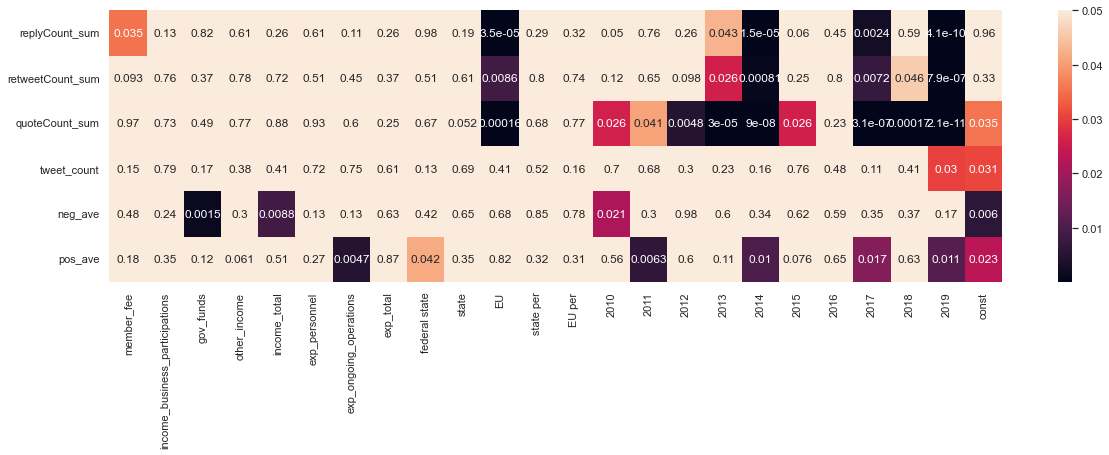

In [22]:
#plot pvalue heatmap, color only significant values (<0.05)
sns.set(rc={'figure.figsize':(20,5)})
pv_fig = sns.heatmap(df_pvalues, annot = True, vmax=0.05)
plt.savefig("plots/p_value_heat.png",bbox_inches='tight')

plt.show()

### 4. Lineplots

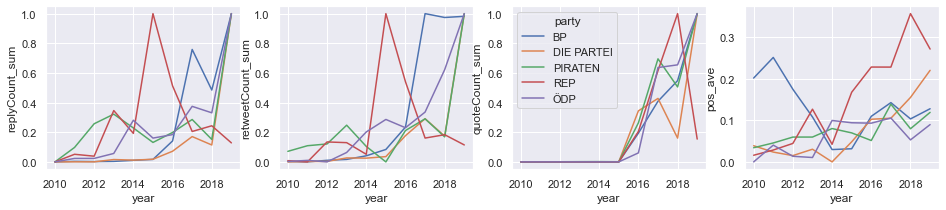

In [29]:
# plot twitter activity and po averege over time
fig, axs = plt.subplots(nrows=1,ncols=4, figsize=(16,3))


sns.lineplot(data=scaled_df,x="year",y="replyCount_sum",hue="party",ax=axs[0],legend=False)

sns.lineplot(data=scaled_df,x="year",y="retweetCount_sum",hue="party",ax=axs[1],legend=False)

sns.lineplot(data=scaled_df,x="year",y="quoteCount_sum",hue="party",ax=axs[2])

sns.lineplot(data=scaled_df,x="year",y="pos_ave",hue="party",ax=axs[3],legend=False)


plt.savefig("plots/lineplot_sig.png",bbox_inches='tight')

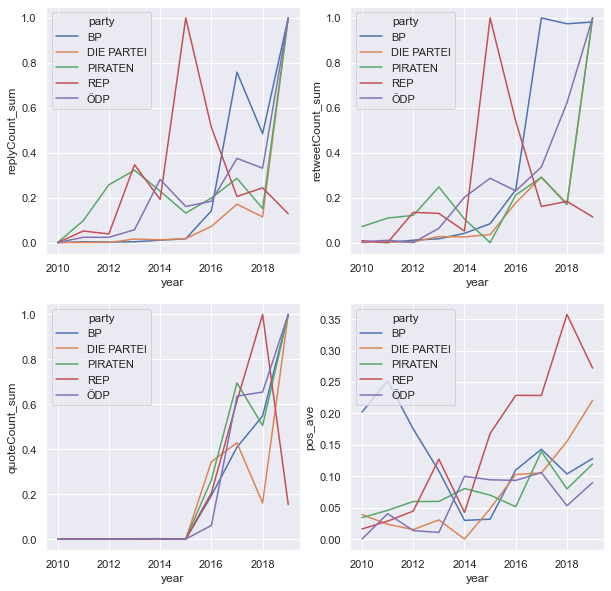

In [118]:
# plot twitter activity and po averege over time
fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(10,10))


sns.lineplot(data=scaled_df,x="year",y="replyCount_sum",hue="party",ax=axs[0,0])

sns.lineplot(data=scaled_df,x="year",y="retweetCount_sum",hue="party",ax=axs[0,1])

sns.lineplot(data=scaled_df,x="year",y="quoteCount_sum",hue="party",ax=axs[1,0])

sns.lineplot(data=scaled_df,x="year",y="pos_ave",hue="party",ax=axs[1,1])


plt.savefig("plots/lineplot_sig_square.png",bbox_inches='tight')


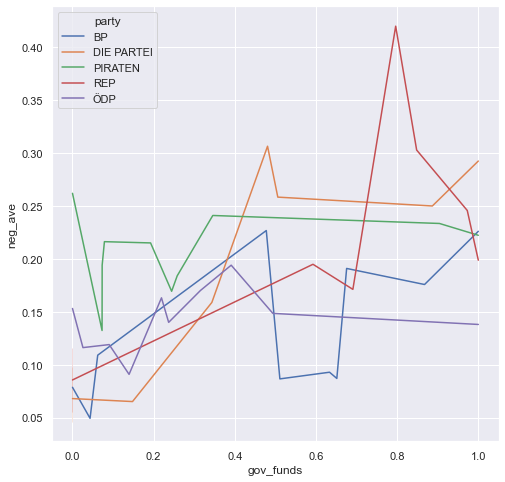

In [120]:
plt.figure(figsize=(8,8))
sns.lineplot(data=scaled_df,x="gov_funds",y="neg_ave",hue="party")

plt.savefig("plots/line_gov_neg.png",bbox_inches='tight')


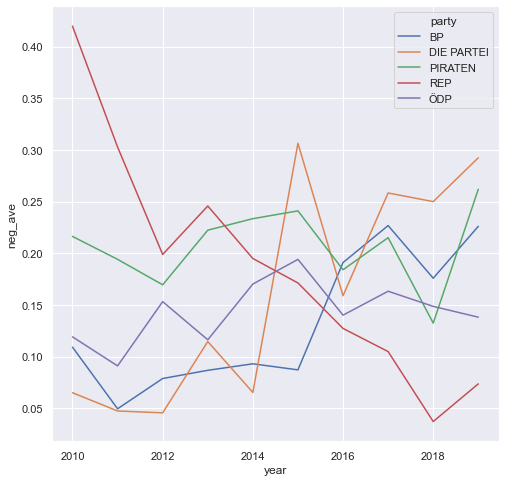

In [121]:
plt.figure(figsize=(8,8))
sns.lineplot(data=scaled_df,x="year",y="neg_ave",hue="party")

plt.savefig("plots/line_year_neg.png",bbox_inches='tight')
